# Práctica 2 - Fundamentos de aprendizaje automático
____
* Pablo Marcos
* Dionisio Pérez


In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np


from Clasificador import ClasificadorVecinosProximos, Clasificador, ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionCruzada
from AnalisisRoc import curva_roc, matriz_confusion
from plotModel import plotModel

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

En primer lugar cargaremos todos los datasets en un array para utilizarlos con los diferentes ejemplos sin cargarlos varias veces.

In [2]:

datasets = []
dataset_names = ('example1','example2','example3','example4','wdbc')


for name in dataset_names:
    datasets.append(Datos("../ConjuntosDatos/{}.data".format(name)))


### Apartado 1 y 3.1 - KNN

Para cada uno de los datasets variaremos el número de vecinos realizando una validación cruzada para calcular el número óptimo de vecinos. También calcularemos con y sin normalización de datos para ver los diferentes resultados.

Por último mostraremos los resultados ploteando la frontera de decisión para el mejor K de cada uno de los datasets.

In [23]:
vecinos = (1, 3, 5, 11, 21, 51)
kfold = ValidacionCruzada(20) # Validacion cruzada con 20 k-folds

# Matriz para guardar los errores
errores_medios = np.empty((len(datasets), len(vecinos), 2))


for i, dataset in enumerate(datasets):
    
    clases = dataset[:,-1]
    
    
    for j, k in enumerate(vecinos):
        for l, normaliza in enumerate((True, False)):
            
            knn = ClasificadorVecinosProximos(k=k, normaliza=normaliza)
            errores = Clasificador.validacion(kfold, dataset, knn)
            errores_medios[i, j, l] = np.mean(errores)


In [5]:
for i, name in enumerate(dataset_names):
    print(name)
    print("K \ Normaliza | No normaliza")
    print(errores_medios[i])
    print()

example1
K \ Normaliza | No normaliza
[[0.18421053 0.17105263]
 [0.16842105 0.13684211]
 [0.16052632 0.13684211]
 [0.11842105 0.14210526]
 [0.13421053 0.13947368]
 [0.15       0.12105263]]

example2
K \ Normaliza | No normaliza
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

example3
K \ Normaliza | No normaliza
[[0.02105263 0.01578947]
 [0.03684211 0.03684211]
 [0.02631579 0.02894737]
 [0.01842105 0.01842105]
 [0.02894737 0.03421053]
 [0.01842105 0.02894737]]

example4
K \ Normaliza | No normaliza
[[0.     0.0375]
 [0.     0.1   ]
 [0.     0.125 ]
 [0.     0.1625]
 [0.     0.3375]
 [0.     0.55  ]]

wdbc
K \ Normaliza | No normaliza
[[0.0462963  0.08333333]
 [0.03518519 0.06666667]
 [0.03888889 0.06481481]
 [0.02777778 0.07222222]
 [0.04444444 0.06666667]
 [0.0462963  0.08518519]]



Observamos los errores medios obtenidos en la validación por cada ejemplo, la matriz imprimida se corresponde por columnas a normalizar o no normalizar y por filas la variación del número de vecinos.
La normalización no cambia significativamente los resultados, obviando el ejemplo 4,...

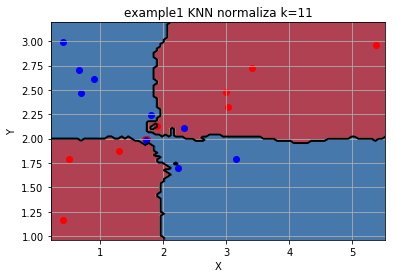

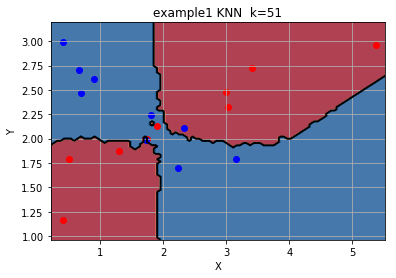

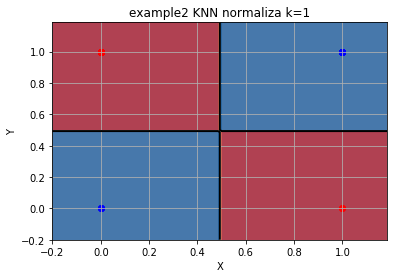

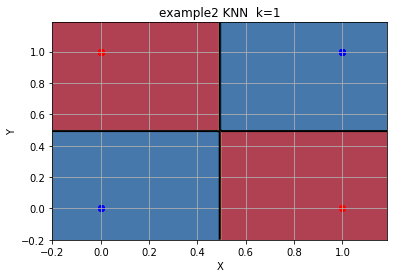

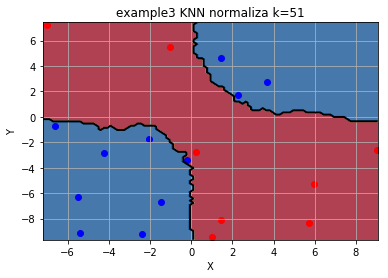

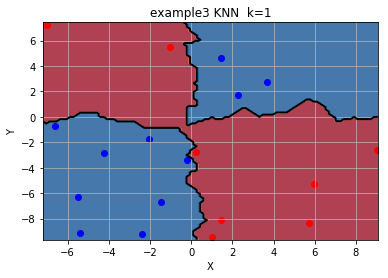

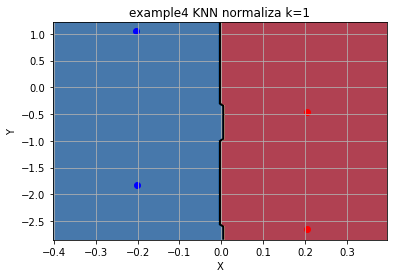

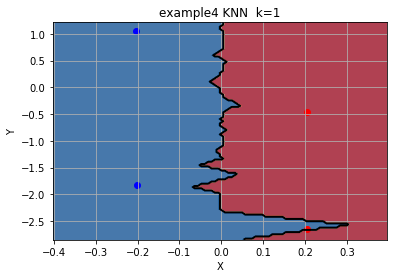

In [6]:
for i, name in enumerate(dataset_names[:-1]):
    particion = kfold(datasets[i])[0]
    for j, normaliza in enumerate((True, False)):
        k = vecinos[np.argmin(errores_medios[i,:,j])]
        knn = ClasificadorVecinosProximos(k=k, normaliza=normaliza)
        knn.entrenamiento(datasets[i], indices=particion.indicesTrain)
        idx = particion.indicesTest
        idx_train = particion.indicesTrain
        title = "{} KNN {} k={}".format(name, "normaliza" if normaliza else "", k)
        plotModel(datasets[i][idx,0],datasets[i][idx,1], datasets[i][idx,2], knn, title, datasets[i].diccionarios)
        plt.show()

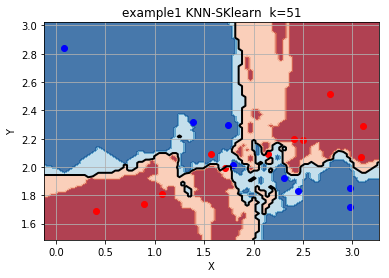

Aciertos utilizando validacion:  90.52631578947368 %


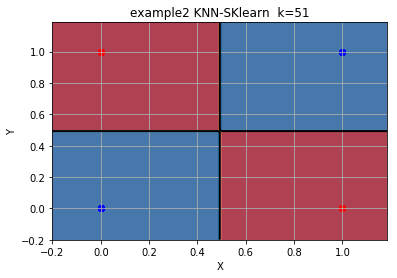

Aciertos utilizando validacion:  100.0 %


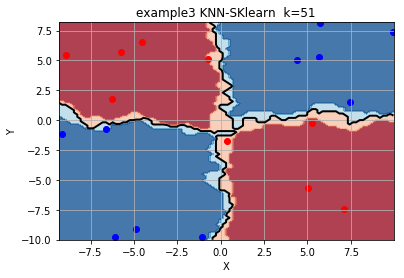

Aciertos utilizando validacion:  98.42105263157895 %


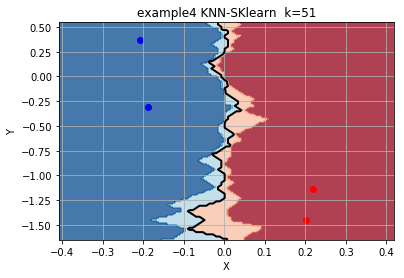

Aciertos utilizando validacion:  97.89473684210527 %


In [46]:
for i, name in enumerate(dataset_names[:-1]):
    particion = kfold(datasets[i])[0]
    idx = particion.indicesTest
    idx_train = particion.indicesTrain
    knnSklearn = KNeighborsClassifier(n_neighbors=3)
    knnSklearn.fit(datasets[i][idx_train,:-1], datasets[i][idx_train,-1])
    title = "{} KNN-SKlearn {} k={}".format(name, "normaliza" if normaliza else "", k)
    plotModel(datasets[i][idx,0],datasets[i][idx,1], datasets[i][idx,2], knnSklearn, title, datasets[i].diccionarios)
    plt.show()
    print("Aciertos utilizando validacion: ",100*knnSklearn.score(datasets[i][idx_train,:-1],datasets[i][idx_train,-1]),"%")


### Apartado 2 y 3.2 - Regresión Logística


En primer lugar calcularemos cual es el mejor numero de epocas y la mejor constante de aprendizaje para minimizar el error cometido en la clasificación, utilizando para ello validación cruzada.

Después mostraremos las fronteras obtenidas para cada una de las epocas con los mejores parámetros

In [ ]:
epochs = (50, 100, 250, 400, 600, 800, 1000)
learn_rates = (.001, .01, .1, .5, 1.)
kfold = ValidacionCruzada(20) # Validacion cruzada con 20 k-folds

# Matriz para guardar los errores
errores_medios = np.zeros((len(datasets), len(epochs), len(epochs)))


for i, dataset in enumerate(datasets):    
    for j, epoch in enumerate(epochs):
        for l, learn_rate in enumerate(learn_rates):
            log = ClasificadorRegresionLogistica(epoch=epoch, learn_rate=learn_rate)
            errores = Clasificador.validacion(kfold, dataset, log)
            errores_medios[i, j, l] = np.mean(errores)


/home/alumnos/e321101/faa/Practica2/Clasificador.py:347: RuntimeWarning: overflow encountered in exp
  s = 1./(1. + np.exp(-np.dot(w,x)))


In [ ]:

def dibujar_fronteras_knn(dataset, dataset_name, k):

    particion = kfold(datasets[i])[0]
    idx_test = particion.indicesTest
    idx_train = particion.indicesTrain
    
    x = dataset[:,0]
    y = dataset[:,1]
    clase = datasets[i][:,-1]
    
    # Knn sin normalizar
    knn = ClasificadorVecinosProximos(k=k, normaliza=False)
    knn.entrenamiento(datasets, indices=particion.indicesTrain)
    
    title = "{} - KNN k={}".format(dataset_name,k)
    plotModel(x[idx_train], y[idx_train], clase[idx_train], knn, title, dataset.diccionarios)
    
    plt.scatter(x[idx_test][clase[idx_test]==0], y[idx_test][clase[idx_test]==0], c='#FFF000')
    plt.scatter(x[idx_test][clase[idx_test]==1], y[idx_test][clase[idx_test]==1], c='#000FFF')

    
    # Knn normalizando
    knn = ClasificadorVecinosProximos(k=k, normaliza=True)
    knn.entrenamiento(dataset, indices=particion.indicesTrain)
    title = "{} - KNN normalizando k={}".format(dataset_name,k)
    plotModel(x[idx_train], y[idx_train], clase[idx_train], knn, title, dataset.diccionarios)
    
    plt.scatter(x[idx_test][clase[idx_test]==0], y[idx_test][clase[idx_test]==0], c='#FFF000')
    plt.scatter(x[idx_test][clase[idx_test]==1], y[idx_test][clase[idx_test]==1], c='#000FFF')

    
    plt.show()

In [ ]:

def dibujar_fronteras_log(dataset, dataset_name, learn_rate, epoch):

    particion = kfold(datasets[i])[0]
    idx_test = particion.indicesTest
    idx_train = particion.indicesTrain
    
    x = dataset[:,0]
    y = dataset[:,1]
    clase = dataset[:,-1]
    
    # Knn sin normalizar
    log = ClasificadorVecinosProximos(k=k, normaliza=False)
    knn.entrenamiento(datasets, indices=particion.indicesTrain)
    
    title = "{} - KNN k={}".format(dataset_name,k)
    plotModel(x[idx_train], y[idx_train], clase[idx_train], knn, title, dataset.diccionarios)
    
    plt.scatter(x[idx_test][clase[idx_test]==0], y[idx_test][clase[idx_test]==0], c='#FFF000')
    plt.scatter(x[idx_test][clase[idx_test]==1], y[idx_test][clase[idx_test]==1], c='#000FFF')

    
    # Knn normalizando
    knn = ClasificadorVecinosProximos(k=k, normaliza=True)
    knn.entrenamiento(dataset, indices=particion.indicesTrain)
    title = "{} - KNN normalizando k={}".format(dataset_name,k)
    plotModel(x[idx_train], y[idx_train], clase[idx_train], knn, title, dataset.diccionarios)
    
    plt.scatter(x[idx_test][clase[idx_test]==0], y[idx_test][clase[idx_test]==0], c='#FFF000')
    plt.scatter(x[idx_test][clase[idx_test]==1], y[idx_test][clase[idx_test]==1], c='#000FFF')

    
    plt.show()

In [ ]:
for i, name in enumerate(dataset_names[:-1]):
    particion = kfold(datasets[i])[0]
    idx = particion.indicesTest
    idx_train = particion.indicesTrain
    logSklearn = LogisticRegression()
    
    logSklearn.fit(datasets[i][idx_train,:-1], datasets[i][idx_train,-1])
    title = "{} log-SKlearn".format(name)
    plotModel(datasets[i][idx,0],datasets[i][idx,1], datasets[i][idx,2], logSklearn, title, datasets[i].diccionarios)
    plt.show()
    print("Aciertos utilizando validacion: ",100*logSklearn.score(datasets[i][idx_train,:-1],datasets[i][idx_train,-1]),"%")







